<a href="https://colab.research.google.com/github/jainrasik/NYC-Taxi-Trip-Time-Prediction-Rasik-Jain/blob/main/NYC_Taxi_Trip_Time_Prediction_rasik_jain_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [2]:
pip install haversine

In [3]:
# importing all the neccessary libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from datetime import datetime
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from geopy.distance import geodesic
from haversine import haversine
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# mounting the drive to colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Reading the file from drive and converting to Dataframe
dir='/content/drive/MyDrive/Colab Notebooks/data files/'
df=pd.read_csv(dir+'NYC Taxi Data.csv',parse_dates=['pickup_datetime','dropoff_datetime'])

In [6]:
# checking the data
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [7]:
df.shape

(1458644, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [8]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [7]:
df.drop('id',axis=1,inplace=True)

In [10]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [8]:
dependent_variable='trip_duration'

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


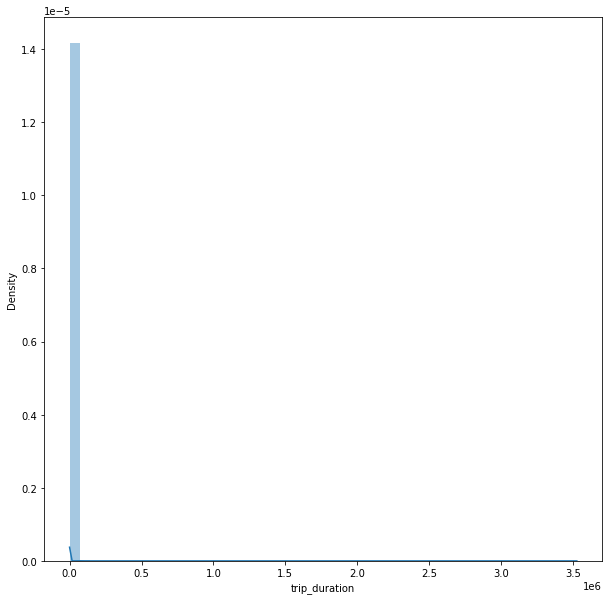

In [12]:
plt.figure(figsize=[10,10])
sns.distplot(df[dependent_variable])

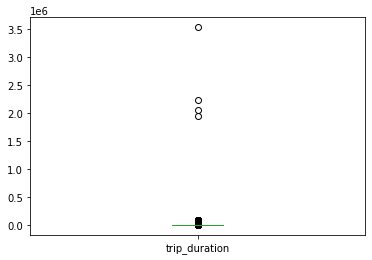

In [13]:
df['trip_duration'].plot(kind='box')

In [14]:
def calculate_trip_duration(pickup,dropoff):
    return (dropoff-pickup).total_seconds()

In [15]:
df['calculate_trip_duration']=df.apply(lambda x: calculate_trip_duration(x['pickup_datetime'],x['dropoff_datetime']),axis=1)

In [16]:
(df['calculate_trip_duration']==df['trip_duration']).value_counts()

True    1458644
dtype: int64

In [17]:
df.drop(['calculate_trip_duration'],axis=1,inplace=True)

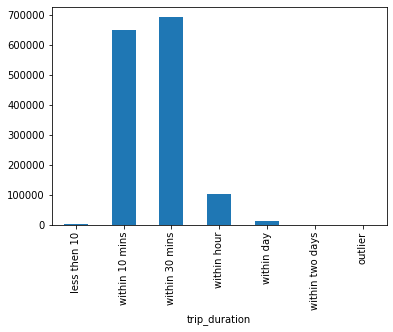

In [18]:
labels=['less then 10','within 10 mins','within 30 mins','within hour','within day','within two days','outlier']
df.groupby(pd.cut(df['trip_duration'],bins=[0,10,600,1800,3600,86400,86400*2,10000000],labels=labels))['trip_duration'].count().plot(kind='bar')

In [9]:
df=df[(df['trip_duration']>10)&(df['trip_duration']<3600)]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'with Transormation')

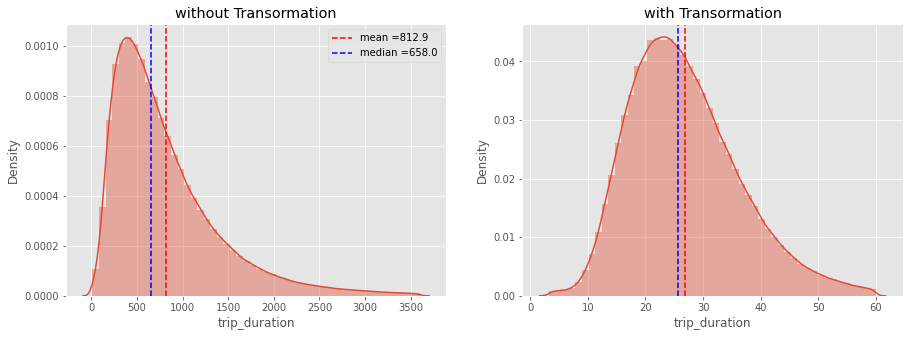

In [20]:
fig=plt.figure(figsize=[15,5])
plt.style.use('ggplot')
x=df[dependent_variable]
y=np.sqrt(df[dependent_variable])
plt.subplot(121)
sns.distplot(x)
ax=fig.gca()
ax.axvline(x.mean(),color='red',linestyle='dashed',label='mean ='+str(round(x.mean(),2)))
ax.axvline(x.median(),color='blue',linestyle='dashed',label='median ='+str(round(x.median(),2)))
ax.set_title('without Transormation')
plt.legend(loc='upper right')
plt.subplot(122)
sns.distplot(y)
ax=fig.gca()
ax.axvline(y.mean(),color='red',linestyle='dashed',label='mean ='+str(round(x.median(),2)))
ax.axvline(y.median(),color='blue',linestyle='dashed',label='median ='+str(round(x.median(),2)))
ax.set_title('with Transormation')

In [10]:
def hvrsine_dist(x1,x2,y1,y2):
    a=(x1,y1)
    b=(x2,y2)
    return haversine(a,b)

In [11]:
df['hvrdistance']=df.apply(lambda x:  hvrsine_dist(x['pickup_latitude'],x['dropoff_latitude'],x['pickup_longitude'],x['dropoff_longitude']),axis=1)

In [23]:
df.hvrdistance.describe()

count    1.444144e+06
mean     3.341909e+00
std      4.082409e+00
min      0.000000e+00
25%      1.230225e+00
50%      2.081785e+00
75%      3.817294e+00
max      1.240910e+03
Name: hvrdistance, dtype: float64

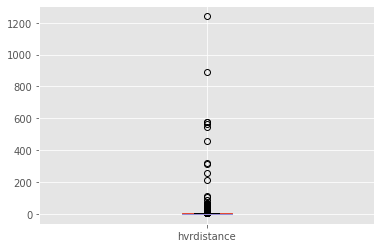

In [24]:
df.hvrdistance.plot(kind='box')

In [12]:
df=df[df['hvrdistance']<50]

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

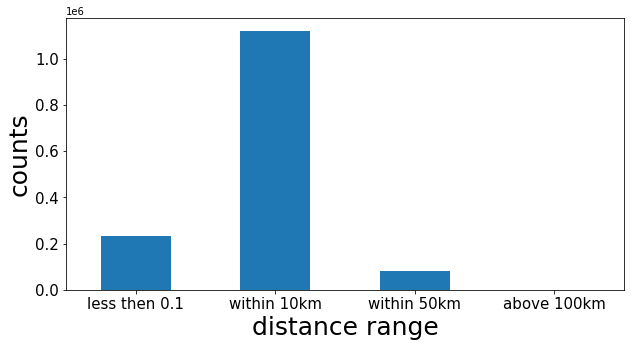

In [12]:
fig=plt.figure(figsize=[10,5])
labels=['less then 0.1','within 10km','within 50km','above 100km']
df.groupby(pd.cut(df.hvrdistance,bins=[0.1,1,10,50,5000],labels=labels))['hvrdistance'].count().plot(kind='bar',fontsize=15)
plt.xlabel('distance range', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.xticks(rotation=0)

In [13]:
df['month'] = df.pickup_datetime.dt.month
df['weekday'] = df.pickup_datetime.dt.weekday
df['pickup_hour'] = df.pickup_datetime.dt.hour

In [28]:
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,hvrdistance,month,weekday,pickup_hour
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498523,3,0,17
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805510,6,6,0
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385107,1,1,11
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485500,4,2,19
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188590,3,5,13


In [ ]:
categorical_variable=set(df.columns)-{'dropoff_datetime','dropoff_latitude','dropoff_longitude','hvrdistance', 'pickup_datetime','pickup_latitude','pickup_longitude', 'trip_duration'}
fig=plt.figure(figsize=[60,20])
for i,col in enumerate(categorical_variable):
  plt.subplot(2,3,i+1)
  df.groupby(col)[col].count().plot(kind='bar',fontsize=25)
  plt.xlabel(col, fontsize=25)
  plt.ylabel('counts', fontsize=25)

In [14]:
df.drop('store_and_fwd_flag',axis=1,inplace=True)

In [15]:
df=df[(df['passenger_count']>0)&(df['passenger_count']<7)]

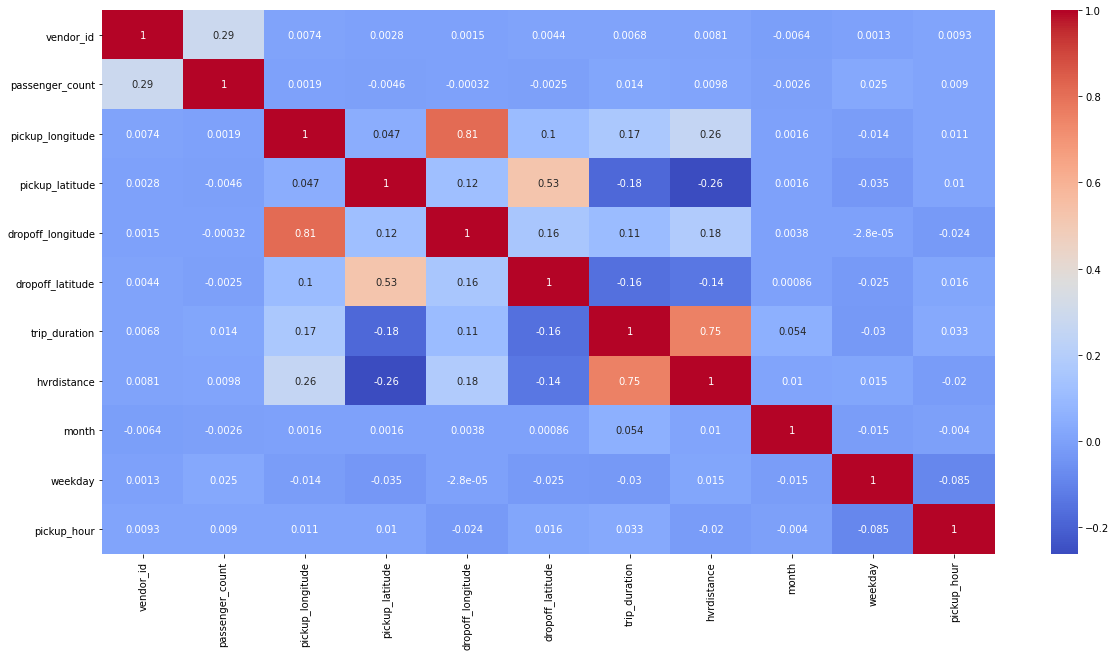

In [16]:
numerical_variable=df.describe().columns
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(df[numerical_variable].corr(),annot=True,cmap='coolwarm')


In [17]:
def calvif(x):
  vif=pd.DataFrame()
  vif['feature']= x.columns
  vif['vif']=[variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
  return vif

In [34]:
independent_numerical_varaible=set(numerical_variable)-{dependent_variable,'dropoff_longitude','dropoff_latitude','vendor_id'}
calvif(df[independent_numerical_varaible])


,feature,vif
0,month,5.371991
1,weekday,3.469370
2,pickup_latitude,670908.074297
3,pickup_hour,5.548874
4,passenger_count,2.606178
5,hvrdistance,1.811998
6,pickup_longitude,670877.079565


In [18]:
df.drop(['pickup_latitude','dropoff_latitude','pickup_longitude','dropoff_longitude'],axis=1,inplace=True)

In [19]:
df.drop(['pickup_datetime','dropoff_datetime'],axis=1,inplace=True)

In [20]:
categorical_variable=set(df.columns)-{'dropoff_datetime','dropoff_latitude','dropoff_longitude','hvrdistance', 'pickup_datetime','pickup_latitude','pickup_longitude', 'trip_duration'}

In [21]:
df=pd.get_dummies(df,columns=categorical_variable)

In [22]:
df.head()

,trip_duration,hvrdistance,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,month_1,month_2,month_3,month_4,month_5,month_6,pickup_hour_0,pickup_hour_1,pickup_hour_2,pickup_hour_3,pickup_hour_4,pickup_hour_5,pickup_hour_6,pickup_hour_7,pickup_hour_8,pickup_hour_9,pickup_hour_10,pickup_hour_11,pickup_hour_12,pickup_hour_13,pickup_hour_14,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,vendor_id_1,vendor_id_2
0,455,1.498523,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,663,1.805510,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2124,6.385107,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,429,1.485500,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,435,1.188590,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [23]:
independent_variable=set(df.columns)-{'trip_duration'}
X=df[independent_variable].values

In [24]:
y=np.log10(df[dependent_variable])
Y=df[dependent_variable]

In [25]:
xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.2,random_state=0)
scaler=MinMaxScaler()
print(xtrain)
xtrain=scaler.fit_transform(xtrain)
xtest=scaler.transform(xtest)
xtrain

[[ 0.         16.8560138   0.         ...  0.          1.
   0.        ]
 [ 0.          8.08159958  0.         ...  0.          0.
   0.        ]
 [ 0.          1.22642429  0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          1.08367696  0.         ...  0.          1.
   0.        ]
 [ 0.          2.98705743  0.         ...  0.          0.
   1.        ]
 [ 0.          1.06565777  0.         ...  0.          0.
   1.        ]]


array([[0.        , 0.33991031, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.16296967, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02473149, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.02185291, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.06023557, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.02148954, 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [27]:
from xgboost import XGBRegressor
xg=XGBRegressor()
xg.fit(xtrain,ytrain)

[15:06:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [30]:
xg.score(xtrain,ytrain)

0.6871915355199096

In [31]:
from lightgbm import LGBMRegressor
lgb=LGBMRegressor()
lgb.fit(xtrain,ytrain)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [32]:
lgb.score(xtrain,ytrain)

0.7161955178715752

In [33]:
from sklearn.ensemble import AdaBoostRegressor
adb=AdaBoostRegressor()
adb.fit(xtrain,ytrain)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [34]:
adb.score(xtrain,ytrain)

0.43073511333695547

In [55]:
regressor=LinearRegression()
regressor.fit(xtrain,ytrain)
regressor.intercept_
regressor.coef_

array([ 9.00548188e+10,  5.20968619e+14,  9.00548186e+10,  9.00548188e+10,
        2.84365214e+14,  6.05922629e+03,  9.00548187e+10,  8.40230824e+13,
        9.00548189e+10,  5.20968619e+14,  5.20968619e+14,  9.00548189e+10,
       -4.99677639e+13,  9.00548189e+10,  9.00548186e+10,  9.00548187e+10,
        9.00548189e+10,  5.20968619e+14,  9.00548189e+10,  2.84365214e+14,
        8.40230824e+13,  9.00548189e+10,  9.00548189e+10,  8.40230824e+13,
        9.00548188e+10,  9.00548187e+10,  5.20968619e+14,  9.00548185e+10,
        9.00548185e+10, -4.99677639e+13,  9.00548188e+10,  9.00548186e+10,
        9.00548187e+10,  9.00548187e+10,  5.20968619e+14,  8.40230824e+13,
        9.00548188e+10,  8.40230824e+13, -4.99677639e+13,  8.40230824e+13,
       -4.99677639e+13, -4.99677639e+13,  9.00548187e+10, -4.99677639e+13,
        5.20968619e+14,  9.00548184e+10])

In [56]:
ypred=regressor.predict(xtest)

In [50]:
regressor.score(xtrain,ytrain)

0.6123340942011528

In [57]:
mean_squared_error(ytest,ypred)

131701.78375960822

In [58]:
r2_score(ytest,ypred)

0.613746961460319

In [51]:
from sklearn.linear_model import Lasso
lasso  = Lasso()

lasso.fit(xtrain, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3266869829.6144714, tolerance: 39468091.947532006
  positive)


Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [52]:
lasso.intercept_
lasso.coef_

array([ 1.16383264e+01, -6.75827883e+01, -1.63299358e+02,  8.29731722e+01,
       -3.47647915e+00,  6.05888123e+03, -5.59311631e+01, -3.21145364e+01,
        9.95526692e+01, -1.15859810e+02,  3.02386251e+01,  1.18059616e+02,
        2.13504073e+01,  1.13053214e+02, -1.35582690e+02, -8.85891170e+01,
        1.04505537e+02,  7.08715744e+00,  1.29610241e+02, -6.17194279e+00,
       -4.01441060e+01,  1.01583890e+02,  1.14687215e+02,  3.15813814e+01,
        8.45324626e+01, -5.10638394e+01, -4.70421763e+01, -2.30891817e+02,
       -2.48566221e+02, -9.28037854e+00,  4.93103996e+01, -1.21045146e+02,
       -8.50548077e+01, -7.69742991e+01,  4.12413906e+01,  2.72765140e+01,
        8.14177798e+01,  1.02943051e+01, -1.63818755e+01, -2.50727469e+01,
        1.18796273e+01,  5.78731938e+00, -6.39852210e+01, -1.02844402e+01,
        2.07141245e+01, -3.39758852e+02])

In [53]:
ypred=lasso.predict(xtest)
lasso.score(xtrain,ytrain)

0.6123392761645451

In [62]:
r2_score(ytest,ypred)

0.613750771979201

In [69]:
from sklearn.linear_model import Ridge
ridge  = Ridge(alpha=10)

ridge.fit(xtrain, ytrain)
ypred=ridge.predict(xtest)
ridge.score(xtrain,ytrain)

0.6123377971765804

In [73]:
from sklearn.model_selection import GridSearchCV
parameters={'alpha':[1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100,0.0014]}
lassoreg=GridSearchCV(lasso,parameters,scoring='r2',cv=5)
lassoreg.fit(xtrain,ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57193414436.18345, tolerance: 31604062.559417237
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58121953791.332985, tolerance: 31607003.70035221
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53958082686.6692, tolerance: 31554116.607328847
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5288274037

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=0.0001, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100, 0.0014]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [74]:
lassoreg.best_params_

{'alpha': 0.0001}

In [ ]:
### Cross validation
from sklearn.model_selection import GridSearchCV
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100,0.0014]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100, 0.0014]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [1]:
lassoreg.scores

NameError: ignored

In [ ]:
fig=plt.figure(figsize=[20,5])
for i,col in enumerate(independent_numerical_varaible):
  plt.subplot(1,4,i+1)
  plt.scatter(df[col],df[dependent_variable])


In [ ]:
fig=plt.figure(figsize=[20,5])
categorical_variable=set(df.columns)-set(df.describe().columns)
for i,col in enumerate(categorical_variable):
  plt.subplot(2,3,i+1)
  df.groupby(col)[col].count().plot(kind='bar')
  plt.title(col)

In [ ]:
numerical_variable=set(df.describe().columns)-{'passenger_count','vendor_id','month','weekday','hour'}
dependent_variable='calculate_trip_duration'
independent_numerical_varaible=set(numerical_variable)-{'calculate_trip_duration'}
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(df[numerical_feature].corr(),annot=True,cmap='coolwarm')

In [ ]:
fig=plt.figure(figsize=[20,5])
for i,col in enumerate(independent_numerical_varaible):
  plt.subplot(2,4,i+1)
  sns.distplot(df[col])
  ax=fig.gca()
  ax.axvline(df[col].mean(),color='red',linestyle='dashed')
  ax.axvline(df[col].median(),color='blue',linestyle='dashed')
  ax.set_title(col)

In [ ]:
fig=plt.figure(figsize=[20,5])
for i,col in enumerate(independent_numerical_varaible):
  plt.subplot(2,4,i+1)
  df[col].hist(bins=50)